# Topic Modeling

In [41]:
#Utilities
from tqdm import tqdm
tqdm.pandas()

#Download resources
import string, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import plotly.express as px
#!jupyter labextension install jupyterlab-plotly



# Compute Coherence Score
import gensim
from gensim import corpora, matutils, models
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet


# NLP
import nltk
from nltk import sent_tokenize, word_tokenize, RegexpParser, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation
nltk.download('wordnet')
nltk.download('stopwords')
import spacy 
#!python -m spacy download en_core_web_sm
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

PATH = ""

/Users/macbookpro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv(PATH+"honest_doc_full.csv")

Visualize

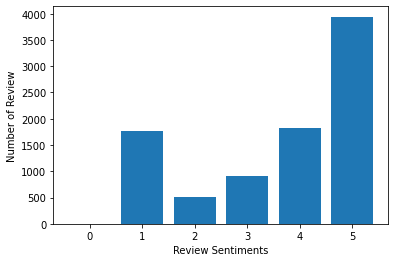

In [ ]:
Sentiment_count=df.groupby('score').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['comment'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [4]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [5]:
data_clean = pd.DataFrame(df.en.apply(round1))

In [6]:
#Using SpaCy to clean Stop Words and use Lemmatization
nlp = en_core_web_sm.load()


punct = string.punctuation
def clean_text_round2(text):
  cleaned_token = []
  doc = nlp(text)
  
  for word in doc:
    if word.lemma_ not in STOP_WORDS and word.lemma_ not in punct:
      cleaned_token.append(word.lemma_)
  return cleaned_token

round2 = lambda x: clean_text_round2(x)

In [7]:
data_clean = pd.DataFrame(data_clean.en.progress_apply(round2))
data_clean = pd.DataFrame(data_clean.en.progress_apply(lambda x:' '.join(x)))
data_clean['score'] = df.score

100%|██████████| 8941/8941 [00:00<00:00, 178752.83it/s]


In [ ]:
#Save to feather file
data_clean.reset_index().to_feather(PATH+'data_clean1.feather')

In [35]:
df = pd.read_feather(PATH+'data_clean.feather', columns=['en','score','hospital'])

### Topic modeling using LDA

In [8]:
mallet_path = PATH+'mallet-2.0.8/bin/mallet' # update this path

In [10]:
#Select only score 1,2 as bad, score 4,5 as good
df = df.loc[df.score != 3]
df['sent'] = 0
df.loc[df.score.isin([4,5]),['sent']]=1


In [11]:
df_train = df.loc[~df.hospital.isin(['โรงพยาบาลตากสิน','โรงพยาบาลรามาธิบดี','โรงพยาบาลพญาไท 2'])]
df_train_good = df_train.loc[df_train.sent==1]
df_train_bad = df_train.loc[df_train.sent==0]

In [12]:
df_test = df.loc[df.hospital.isin(['โรงพยาบาลตากสิน','โรงพยาบาลรามาธิบดี','โรงพยาบาลพญาไท 2'])]
df_test_good = df_test.loc[df_test.sent==1]
df_test_bad = df_test.loc[df_test.sent==0]

In [13]:

#Also use stop words from NLTK
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'it', 'aaa', 'ใใ', 'pron','zone', 'yama', 'young', 'york', 'yesterday', 'yeah', 'woman', 'yu'])

cv = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range = (1,1))

In [14]:
#Positive sentiment
data_cv_good= cv.fit_transform(df_train_good['en'])
data_dtm_good = pd.DataFrame(data_cv_good.toarray(), columns=cv.get_feature_names())
data_dtm_good.index = df_train_good.index

In [15]:
#Negaive sentiment
data_cv_bad= cv.fit_transform(df_train_bad['en'])
data_dtm_bad = pd.DataFrame(data_cv_bad.toarray(), columns=cv.get_feature_names())
data_dtm_bad.index = df_train_bad.index

In [ ]:
data_dtm_good.sum().sort_values(ascending=False)

good            5716
doctor          5518
service         3702
hospital        3559
nurse           2680
                ... 
order lunch        1
order longer       1
order leave        1
order lack         1
abak               1
Length: 57223, dtype: int64

In [9]:
data_dtm_bad.sum().sort_values(ascending=False)

nurse           36
patient         31
time            27
doctor          26
hospital        25
wait            24
service         23
bad             18
staff           17
ask             17
come            15
speak           14
people          14
work            14
know            13
room            12
queue           12
talk            12
treatment       11
terrible        11
good            10
like             9
minute           9
relative         9
badly            9
afternoon        9
lot              8
want             8
department       8
sit              8
                ..
kun              1
invest           1
large            1
layer            1
screening        1
learn            1
sacred           1
let              1
rummage          1
iron             1
instead          1
shock            1
send             1
huge             1
shame            1
seven            1
image            1
imagine          1
impressed        1
imprint          1
improvement      1
inspect     

## Topic Modeling

In [17]:
#Start with bad topic
tdm = data_dtm_bad.T
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
#Create Dictionary
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
word2id = dict((k, v) for k, v in cv.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [18]:
#Compute coherence scores from varying number of Topics with LdaMallet
def Coherence(max_topic=8,text=df_train_bad.en):
    mallet_path = PATH+'mallet-2.0.8/bin/mallet' # update this path
    qe = text.progress_apply(round2)
    coherence = []
    for i in tqdm(range(1,max_topic+1)):
        #Use LDAMallet, often gave a better result
        lda = models.wrappers.LdaMallet(mallet_path,alpha=0.1, 
                                               corpus=corpus, num_topics=i, 
                                               id2word=id2word, random_seed=123)        
        topics = lda.print_topics()
        print(f'\nNumber of topic: {i} \n')
        for topic in topics:
            print(topic)
        coherence_model_lda = CoherenceModel(model=lda, texts=qe, dictionary=d, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence.append(coherence_lda)
        print(f'\n Coherence Score: {coherence_lda}')
    plt.plot(range(1,max_topic+1),coherence,label='Coherence')
    plt.xlabel('Coherence')
    plt.ylabel('Score')
    plt.xticks(range(1,max_topic+1))
    plt.show()
      

  0%|          | 0/8 [00:00<?, ?it/s]


Number of topic: 1 

(0, '0.042*"doctor" + 0.027*"hospital" + 0.026*"wait" + 0.022*"patient" + 0.022*"service" + 0.019*"nurse" + 0.018*"time" + 0.015*"bad" + 0.012*"good" + 0.011*"check"')


 12%|█▎        | 1/8 [00:37<04:24, 37.75s/it]


 Coherence Score: 0.3634882908739515

Number of topic: 2 

(0, '0.056*"wait" + 0.040*"doctor" + 0.031*"time" + 0.024*"patient" + 0.021*"hospital" + 0.021*"service" + 0.020*"check" + 0.018*"long" + 0.016*"hour" + 0.013*"queue"')
(1, '0.044*"doctor" + 0.031*"hospital" + 0.025*"nurse" + 0.023*"service" + 0.021*"patient" + 0.017*"good" + 0.016*"bad" + 0.013*"room" + 0.011*"speak" + 0.009*"people"')


 25%|██▌       | 2/8 [01:15<03:47, 37.88s/it]


 Coherence Score: 0.3704364690752092

Number of topic: 3 

(0, '0.073*"wait" + 0.041*"doctor" + 0.035*"time" + 0.028*"patient" + 0.024*"long" + 0.023*"check" + 0.019*"hour" + 0.019*"service" + 0.018*"hospital" + 0.018*"queue"')
(1, '0.045*"service" + 0.035*"nurse" + 0.028*"hospital" + 0.026*"patient" + 0.026*"good" + 0.023*"bad" + 0.018*"doctor" + 0.018*"speak" + 0.017*"people" + 0.013*"staff"')
(2, '0.066*"doctor" + 0.034*"hospital" + 0.013*"patient" + 0.012*"medicine" + 0.012*"time" + 0.012*"day" + 0.011*"room" + 0.010*"nurse" + 0.010*"check" + 0.009*"treatment"')


 38%|███▊      | 3/8 [01:54<03:10, 38.11s/it]


 Coherence Score: 0.380174470101489

Number of topic: 4 

(0, '0.076*"wait" + 0.043*"doctor" + 0.037*"time" + 0.028*"patient" + 0.025*"long" + 0.022*"check" + 0.020*"hour" + 0.020*"hospital" + 0.019*"queue" + 0.017*"service"')
(1, '0.054*"hospital" + 0.042*"service" + 0.021*"pay" + 0.016*"security" + 0.016*"money" + 0.016*"expensive" + 0.014*"patient" + 0.014*"good" + 0.013*"bad" + 0.013*"room"')
(2, '0.044*"nurse" + 0.038*"service" + 0.030*"patient" + 0.026*"good" + 0.025*"bad" + 0.022*"doctor" + 0.021*"speak" + 0.021*"hospital" + 0.017*"people" + 0.014*"room"')
(3, '0.080*"doctor" + 0.026*"hospital" + 0.013*"medicine" + 0.013*"day" + 0.013*"patient" + 0.013*"check" + 0.010*"nurse" + 0.010*"fever" + 0.010*"time" + 0.010*"symptom"')


 50%|█████     | 4/8 [02:33<02:33, 38.27s/it]


 Coherence Score: 0.3808249435004424

Number of topic: 5 

(0, '0.087*"wait" + 0.040*"time" + 0.037*"doctor" + 0.028*"patient" + 0.028*"long" + 0.025*"hour" + 0.024*"check" + 0.023*"queue" + 0.019*"sit" + 0.018*"service"')
(1, '0.043*"hospital" + 0.021*"wound" + 0.019*"patient" + 0.018*"parking" + 0.017*"car" + 0.016*"park" + 0.015*"room" + 0.013*"nurse" + 0.012*"service" + 0.010*"walk"')
(2, '0.050*"nurse" + 0.034*"room" + 0.030*"hospital" + 0.020*"patient" + 0.019*"child" + 0.018*"service" + 0.017*"doctor" + 0.017*"good" + 0.013*"bad" + 0.012*"emergency"')
(3, '0.056*"service" + 0.028*"patient" + 0.027*"good" + 0.027*"bad" + 0.027*"nurse" + 0.026*"hospital" + 0.025*"doctor" + 0.023*"speak" + 0.020*"staff" + 0.018*"people"')
(4, '0.092*"doctor" + 0.028*"hospital" + 0.017*"check" + 0.016*"medicine" + 0.015*"day" + 0.014*"patient" + 0.014*"time" + 0.012*"pay" + 0.011*"symptom" + 0.009*"wait"')


 62%|██████▎   | 5/8 [03:12<01:55, 38.52s/it]


 Coherence Score: 0.3761676713041244

Number of topic: 6 

(0, '0.037*"room" + 0.034*"nurse" + 0.034*"hospital" + 0.015*"child" + 0.015*"patient" + 0.015*"emergency" + 0.014*"wound" + 0.013*"service" + 0.013*"bed" + 0.013*"sleep"')
(1, '0.054*"service" + 0.037*"nurse" + 0.033*"patient" + 0.032*"good" + 0.028*"bad" + 0.025*"speak" + 0.023*"hospital" + 0.023*"people" + 0.016*"doctor" + 0.016*"work"')
(2, '0.079*"doctor" + 0.028*"nurse" + 0.023*"patient" + 0.018*"hospital" + 0.016*"bad" + 0.015*"check" + 0.014*"speak" + 0.012*"child" + 0.011*"room" + 0.011*"time"')
(3, '0.090*"wait" + 0.039*"time" + 0.036*"doctor" + 0.029*"long" + 0.029*"patient" + 0.025*"check" + 0.024*"queue" + 0.024*"hour" + 0.020*"sit" + 0.017*"hospital"')
(4, '0.094*"doctor" + 0.019*"medicine" + 0.019*"hospital" + 0.017*"day" + 0.016*"time" + 0.016*"check" + 0.014*"wait" + 0.013*"symptom" + 0.012*"patient" + 0.011*"drug"')
(5, '0.051*"hospital" + 0.038*"service" + 0.027*"pay" + 0.021*"bad" + 0.020*"doctor" + 0.020*"

 75%|███████▌  | 6/8 [03:51<01:17, 38.66s/it]


 Coherence Score: 0.3936878851851771

Number of topic: 7 

(0, '0.089*"wait" + 0.039*"time" + 0.038*"doctor" + 0.032*"long" + 0.026*"hour" + 0.025*"patient" + 0.024*"queue" + 0.023*"service" + 0.021*"security" + 0.021*"social"')
(1, '0.056*"wait" + 0.039*"time" + 0.036*"doctor" + 0.034*"patient" + 0.032*"appointment" + 0.029*"check" + 0.021*"hospital" + 0.017*"long" + 0.015*"nurse" + 0.013*"work"')
(2, '0.063*"doctor" + 0.049*"hospital" + 0.024*"pay" + 0.019*"treatment" + 0.017*"patient" + 0.016*"money" + 0.015*"baht" + 0.014*"expensive" + 0.013*"medicine" + 0.012*"insurance"')
(3, '0.051*"nurse" + 0.040*"room" + 0.030*"hospital" + 0.021*"patient" + 0.017*"emergency" + 0.017*"child" + 0.015*"bed" + 0.014*"wound" + 0.013*"service" + 0.012*"bad"')
(4, '0.052*"service" + 0.038*"hospital" + 0.023*"parking" + 0.021*"park" + 0.020*"people" + 0.018*"staff" + 0.017*"car" + 0.013*"lot" + 0.013*"building" + 0.011*"customer"')
(5, '0.107*"doctor" + 0.018*"medicine" + 0.017*"check" + 0.016*"day" 

 88%|████████▊ | 7/8 [04:30<00:38, 38.83s/it]


 Coherence Score: 0.4185451112405845

Number of topic: 8 

(0, '0.041*"room" + 0.033*"hospital" + 0.027*"nurse" + 0.019*"park" + 0.018*"service" + 0.017*"parking" + 0.016*"car" + 0.016*"bed" + 0.014*"patient" + 0.012*"walk"')
(1, '0.094*"wait" + 0.039*"time" + 0.037*"doctor" + 0.031*"long" + 0.026*"patient" + 0.025*"check" + 0.025*"sit" + 0.024*"hour" + 0.020*"service" + 0.018*"queue"')
(2, '0.078*"doctor" + 0.035*"hospital" + 0.020*"fever" + 0.019*"check" + 0.018*"medicine" + 0.016*"child" + 0.014*"baht" + 0.014*"pay" + 0.013*"time" + 0.012*"blood"')
(3, '0.053*"wait" + 0.034*"time" + 0.033*"doctor" + 0.029*"patient" + 0.028*"appointment" + 0.026*"hospital" + 0.023*"queue" + 0.021*"check" + 0.016*"long" + 0.015*"card"')
(4, '0.066*"service" + 0.048*"hospital" + 0.035*"good" + 0.027*"bad" + 0.023*"patient" + 0.020*"nurse" + 0.019*"doctor" + 0.018*"staff" + 0.017*"people" + 0.013*"pay"')
(5, '0.051*"doctor" + 0.032*"patient" + 0.030*"hospital" + 0.028*"security" + 0.026*"social" + 0.02

100%|██████████| 8/8 [05:09<00:00, 38.73s/it]


 Coherence Score: 0.3999643584330307


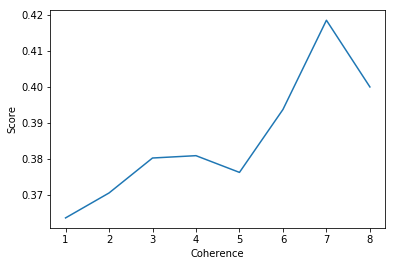

In [69]:
#This line using TRAINING data
Coherence(max_topic=8)

In [70]:
#7 Topics seems gave best result
lda = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)        
lda.show_topics(formatted=False)

[(0,
  [('service', 0.13235729074238392),
   ('people', 0.07216799763383615),
   ('work', 0.04717539189588879),
   ('lot', 0.03223898254954156),
   ('staff', 0.03076013013901213),
   ('bad', 0.028689736764270925),
   ('improve', 0.026915113871635612),
   ('sick', 0.024548950014788525),
   ('poor', 0.02336586808636498),
   ('word', 0.01789411416740609)]),
 (1,
  [('room', 0.06426470588235295),
   ('walk', 0.029558823529411766),
   ('card', 0.027205882352941177),
   ('today', 0.023823529411764705),
   ('staff', 0.021029411764705883),
   ('floor', 0.018823529411764704),
   ('answer', 0.018235294117647058),
   ('receive', 0.017941176470588235),
   ('find', 0.01661764705882353),
   ('die', 0.015588235294117648)]),
 (2,
  [('wait', 0.17734420500873616),
   ('time', 0.12157833430401864),
   ('check', 0.07833430401863715),
   ('long', 0.05634828188701223),
   ('hour', 0.050087361677344205),
   ('sit', 0.04266161910308678),
   ('queue', 0.0401863715783343),
   ('appointment', 0.0288293535235876

In [20]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, d)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.048783 -0.008581       1        1  32.965969
2      0.070180 -0.021395       2        1  31.012478
0     -0.082503 -0.065440       3        1  30.468992
1     -0.036460  0.095417       4        1   5.552566, topic_info=          Term       Freq      Total Category  logprob  loglift
132  relatives   5.000000   5.000000  Default  30.0000  30.0000
67         see   7.000000   7.000000  Default  29.0000  29.0000
430       long   5.000000   5.000000  Default  28.0000  28.0000
4       doctor  16.000000  16.000000  Default  27.0000  27.0000
142       make   2.000000   2.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
375     better   0.445491   2.488056   Topic4  -5.2553   1.1708
55     waiting   0.444798   9.927621   Topic4  -5.2568  -0.2145
511  provinces   0.444519   1.753187   Topic4  -5.2574   1.5187
372       much   0.444501   2.489109   Topic4  -5.2575   1.1682
431       cost   0.444307   1.745716   Topic4  -5.2579   1.5225

[261 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
331       3  0.936996     16
470       2  0.571609     20
9         2  0.943422    2nd
416       2  0.943369     30
21        1  0.324478     39
...     ...       ...    ...
291       3  0.392317   well
275       1  0.271896   work
275       2  0.135948   work
275       3  0.679739   work
395       1  0.926845  wrong

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [57]:
lda.show_topics(formatted=False)

[(0,
  [('service', 0.04121847),
   ('patient', 0.027416822),
   ('nurse', 0.025830353),
   ('room', 0.022302276),
   ('bad', 0.015873116),
   ('like', 0.015013336),
   ('time', 0.014311581),
   ('come', 0.012853467),
   ('work', 0.012802393),
   ('wait', 0.012541692)]),
 (1,
  [('doctor', 0.06082735),
   ('wait', 0.03979995),
   ('patient', 0.020328587),
   ('time', 0.020310897),
   ('come', 0.019075537),
   ('check', 0.016226815),
   ('ask', 0.014612094),
   ('nurse', 0.012627413),
   ('long', 0.012564963),
   ('hospital', 0.01171927)]),
 (2,
  [('hospital', 0.047644094),
   ('doctor', 0.036392514),
   ('security', 0.019223727),
   ('social', 0.017362215),
   ('nurse', 0.016127566),
   ('patient', 0.015437975),
   ('time', 0.014883267),
   ('pay', 0.013219282),
   ('ask', 0.01230991),
   ('like', 0.011155779)]),
 (3,
  [('hospital', 0.034471124),
   ('service', 0.02996269),
   ('patient', 0.021941245),
   ('expensive', 0.015606896),
   ('good', 0.013502101),
   ('like', 0.013182239),

## Ramathibodi hospital

In [19]:
#Test data
#Choose the hopsital to test
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].en)
data_dtm_bad = pd.DataFrame(data_cv_bad.toarray(), columns=cv.get_feature_names())
data_dtm_bad.index = df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].index

tdm = data_dtm_bad.T
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
#Create Dictionary
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
word2id = dict((k, v) for k, v in cv.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id
ldaR = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)        
ldaR.show_topics(formatted=False)


[(0,
  [('nurse', 0.13541666666666666),
   ('doctor', 0.09895833333333333),
   ('patient', 0.052083333333333336),
   ('talk', 0.041666666666666664),
   ('person', 0.03125),
   ('doctors', 0.026041666666666668),
   ('told', 0.020833333333333332),
   ('sitting', 0.020833333333333332),
   ('answer', 0.020833333333333332),
   ('appointment', 0.020833333333333332)]),
 (1,
  [('terrible', 0.07534246575342465),
   ('work', 0.06164383561643835),
   ('badly', 0.06164383561643835),
   ('poor', 0.04794520547945205),
   ('floor', 0.04794520547945205),
   ('nurses', 0.04794520547945205),
   ('card', 0.0410958904109589),
   ('blood', 0.03424657534246575),
   ('er', 0.0273972602739726),
   ('talking', 0.02054794520547945)]),
 (2,
  [('bad', 0.10714285714285714),
   ('room', 0.06547619047619048),
   ('relatives', 0.047619047619047616),
   ('emergency', 0.041666666666666664),
   ('receive', 0.02976190476190476),
   ('hospital', 0.02976190476190476),
   ('medicine', 0.023809523809523808),
   ('bed', 0.0

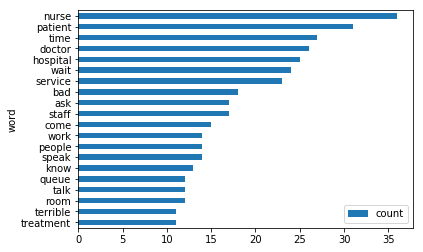

In [32]:
# most frequent words
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

## Taksin Hospital

In [27]:
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลตากสิน'].en)
data_dtm_bad = pd.DataFrame(data_cv_bad.toarray(), columns=cv.get_feature_names())
data_dtm_bad.index = df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลตากสิน'].index

tdm = data_dtm_bad.T
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
#Create Dictionary
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
word2id = dict((k, v) for k, v in cv.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id
ldaT = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)        
ldaT.show_topics(formatted=False)

[(0,
  [('hospital', 0.13653136531365315),
   ('patient', 0.08118081180811808),
   ('service', 0.07011070110701106),
   ('lot', 0.02952029520295203),
   ('wait', 0.025830258302583026),
   ('staff', 0.02214022140221402),
   ('poor', 0.02214022140221402),
   ('send', 0.01845018450184502),
   ('terrible', 0.01845018450184502),
   ('medical', 0.01845018450184502)]),
 (1,
  [('nurse', 0.12448132780082988),
   ('people', 0.07468879668049792),
   ('bad', 0.058091286307053944),
   ('good', 0.03319502074688797),
   ('treatment', 0.024896265560165973),
   ('answer', 0.024896265560165973),
   ('talk', 0.02074688796680498),
   ('meet', 0.016597510373443983),
   ('mother', 0.016597510373443983),
   ('word', 0.016597510373443983)]),
 (2,
  [('doctor', 0.1278538812785388),
   ('work', 0.0547945205479452),
   ('sit', 0.045662100456621),
   ('speak', 0.0365296803652968),
   ('security', 0.0273972602739726),
   ('face', 0.0228310502283105),
   ('social', 0.0228310502283105),
   ('wear', 0.02283105022831

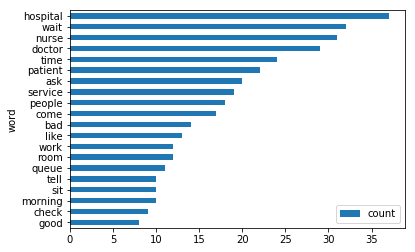

In [29]:
# most frequent words
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

## Phyathai 2 Hospital

In [21]:
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลพญาไท 2'].en)
data_dtm_bad = pd.DataFrame(data_cv_bad.toarray(), columns=cv.get_feature_names())
data_dtm_bad.index = df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลพญาไท 2'].index

tdm = data_dtm_bad.T
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
#Create Dictionary
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
word2id = dict((k, v) for k, v in cv.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id
ldaP = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)        
ldaP.show_topics(formatted=False)

[(0,
  [('service', 0.08303249097472924),
   ('wait', 0.06859205776173286),
   ('staff', 0.061371841155234655),
   ('people', 0.05054151624548736),
   ('queue', 0.04332129963898917),
   ('terrible', 0.039711191335740074),
   ('department', 0.02527075812274368),
   ('long', 0.02527075812274368),
   ('card', 0.021660649819494584),
   ('check', 0.018050541516245487)]),
 (1,
  [('patient', 0.10431654676258993),
   ('work', 0.050359712230215826),
   ('speak', 0.050359712230215826),
   ('room', 0.04316546762589928),
   ('relative', 0.02877697841726619),
   ('badly', 0.02877697841726619),
   ('talk', 0.02877697841726619),
   ('sit', 0.02877697841726619),
   ('system', 0.025179856115107913),
   ('sick', 0.025179856115107913)]),
 (2,
  [('time', 0.0896551724137931),
   ('doctor', 0.0896551724137931),
   ('minute', 0.03103448275862069),
   ('afternoon', 0.03103448275862069),
   ('lot', 0.027586206896551724),
   ('poor', 0.02413793103448276),
   ('person', 0.020689655172413793),
   ('day', 0.0172

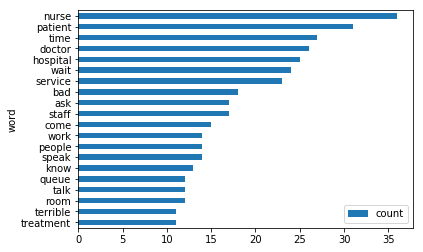

In [26]:
# most frequent words
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

## **LDA from Nouns only**

In [ ]:

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [ ]:
data_nouns = df_train_bad.en.progress_apply(nouns)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'it', 'aaa', 'ใใ', 'pron','zone', 'yama', 'young', 'york', 'yesterday', 'yeah', 'woman', 'yu'])

cvn = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range = (1,1))
data_cvn= cvn.fit_transform(data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

In [67]:
# Create the gensim corpus
corpus = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2word = dict((v, k) for k, v in cvn.vocabulary_.items())

In [68]:
id2word = dict((v, k) for k, v in cvn.vocabulary_.items())
word2id = dict((k, v) for k, v in cvn.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

  0%|          | 0/8 [00:00<?, ?it/s]


Number of topic: 1 

(0, '0.062*"doctor" + 0.035*"hospital" + 0.033*"service" + 0.027*"time" + 0.025*"wait" + 0.021*"patient" + 0.017*"room" + 0.016*"people" + 0.013*"check" + 0.011*"staff"')


 12%|█▎        | 1/8 [00:37<04:22, 37.51s/it]


 Coherence Score: 0.4858509009210608

Number of topic: 2 

(0, '0.068*"service" + 0.050*"wait" + 0.043*"patient" + 0.034*"room" + 0.032*"people" + 0.026*"check" + 0.023*"staff" + 0.022*"time" + 0.022*"hour" + 0.020*"nurse"')
(1, '0.122*"doctor" + 0.068*"hospital" + 0.031*"time" + 0.022*"security" + 0.022*"day" + 0.019*"pay" + 0.018*"treatment" + 0.018*"medicine" + 0.014*"department" + 0.014*"money"')


 25%|██▌       | 2/8 [01:14<03:44, 37.49s/it]


 Coherence Score: 0.5367926402620433

Number of topic: 3 

(0, '0.182*"doctor" + 0.032*"day" + 0.026*"medicine" + 0.017*"appointment" + 0.017*"treat" + 0.016*"home" + 0.015*"child" + 0.015*"care" + 0.014*"drug" + 0.014*"blood"')
(1, '0.075*"time" + 0.074*"wait" + 0.063*"patient" + 0.051*"room" + 0.047*"people" + 0.038*"check" + 0.033*"hour" + 0.030*"nurse" + 0.023*"sit" + 0.019*"emergency"')
(2, '0.105*"hospital" + 0.101*"service" + 0.034*"staff" + 0.034*"security" + 0.030*"pay" + 0.029*"work" + 0.029*"treatment" + 0.022*"department" + 0.022*"money" + 0.022*"speak"')


 38%|███▊      | 3/8 [01:52<03:07, 37.45s/it]


 Coherence Score: 0.518117472419486

Number of topic: 4 

(0, '0.080*"service" + 0.079*"patient" + 0.070*"room" + 0.042*"nurse" + 0.040*"people" + 0.029*"speak" + 0.026*"emergency" + 0.025*"talk" + 0.022*"child" + 0.021*"care"')
(1, '0.234*"doctor" + 0.048*"check" + 0.041*"day" + 0.034*"medicine" + 0.022*"examination" + 0.021*"treat" + 0.021*"today" + 0.018*"drug" + 0.018*"blood" + 0.015*"eat"')
(2, '0.108*"time" + 0.100*"wait" + 0.056*"service" + 0.045*"staff" + 0.044*"hour" + 0.039*"work" + 0.031*"sit" + 0.030*"department" + 0.024*"appointment" + 0.024*"people"')
(3, '0.139*"hospital" + 0.045*"security" + 0.040*"pay" + 0.038*"treatment" + 0.029*"money" + 0.028*"lot" + 0.022*"home" + 0.015*"year" + 0.014*"change" + 0.014*"car"')


 50%|█████     | 4/8 [02:29<02:29, 37.50s/it]


 Coherence Score: 0.4911569432282037

Number of topic: 5 

(0, '0.171*"service" + 0.086*"room" + 0.080*"people" + 0.058*"staff" + 0.036*"speak" + 0.031*"talk" + 0.030*"emergency" + 0.025*"person" + 0.020*"word" + 0.016*"feel"')
(1, '0.131*"time" + 0.121*"wait" + 0.090*"patient" + 0.063*"check" + 0.054*"hour" + 0.046*"work" + 0.038*"sit" + 0.036*"department" + 0.030*"appointment" + 0.028*"today"')
(2, '0.058*"security" + 0.052*"nurse" + 0.036*"lot" + 0.029*"home" + 0.026*"card" + 0.021*"floor" + 0.020*"walk" + 0.019*"answer" + 0.018*"car" + 0.017*"insurance"')
(3, '0.174*"hospital" + 0.050*"pay" + 0.047*"treatment" + 0.036*"money" + 0.029*"treat" + 0.026*"child" + 0.026*"care" + 0.018*"year" + 0.018*"night" + 0.017*"mother"')
(4, '0.292*"doctor" + 0.049*"day" + 0.042*"medicine" + 0.023*"drug" + 0.022*"blood" + 0.020*"morning" + 0.018*"eat" + 0.018*"minute" + 0.017*"month" + 0.016*"symptom"')


 62%|██████▎   | 5/8 [03:07<01:52, 37.52s/it]


 Coherence Score: 0.48579170850170017

Number of topic: 6 

(0, '0.067*"security" + 0.066*"day" + 0.048*"hospital" + 0.041*"lot" + 0.036*"appointment" + 0.029*"today" + 0.026*"morning" + 0.022*"answer" + 0.021*"month" + 0.021*"change"')
(1, '0.159*"time" + 0.147*"wait" + 0.076*"check" + 0.065*"hour" + 0.046*"sit" + 0.044*"department" + 0.031*"card" + 0.029*"person" + 0.028*"queue" + 0.024*"system"')
(2, '0.204*"service" + 0.095*"people" + 0.069*"staff" + 0.059*"work" + 0.022*"year" + 0.019*"place" + 0.016*"eye" + 0.014*"matter" + 0.014*"customer" + 0.014*"attention"')
(3, '0.158*"hospital" + 0.100*"room" + 0.059*"pay" + 0.051*"treatment" + 0.043*"money" + 0.037*"emergency" + 0.021*"night" + 0.017*"fee" + 0.016*"home" + 0.016*"baht"')
(4, '0.134*"patient" + 0.064*"nurse" + 0.045*"speak" + 0.038*"talk" + 0.033*"child" + 0.032*"care" + 0.026*"floor" + 0.025*"walk" + 0.025*"word" + 0.021*"mother"')
(5, '0.346*"doctor" + 0.050*"medicine" + 0.032*"examination" + 0.032*"treat" + 0.027*"drug"

 75%|███████▌  | 6/8 [03:45<01:15, 37.64s/it]


 Coherence Score: 0.4338898268085425

Number of topic: 7 

(0, '0.293*"doctor" + 0.047*"check" + 0.043*"security" + 0.041*"examination" + 0.040*"today" + 0.026*"year" + 0.025*"answer" + 0.022*"pain" + 0.019*"eye" + 0.016*"matter"')
(1, '0.237*"hospital" + 0.069*"pay" + 0.050*"money" + 0.036*"child" + 0.036*"security" + 0.024*"car" + 0.022*"fever" + 0.021*"place" + 0.019*"baht" + 0.018*"park"')
(2, '0.180*"time" + 0.167*"wait" + 0.074*"hour" + 0.052*"sit" + 0.041*"check" + 0.041*"appointment" + 0.032*"blood" + 0.031*"queue" + 0.026*"minute" + 0.023*"waste"')
(3, '0.119*"room" + 0.045*"emergency" + 0.039*"home" + 0.036*"care" + 0.031*"morning" + 0.029*"day" + 0.027*"walk" + 0.025*"night" + 0.025*"card" + 0.024*"mother"')
(4, '0.230*"service" + 0.094*"people" + 0.077*"staff" + 0.066*"work" + 0.049*"department" + 0.048*"lot" + 0.028*"system" + 0.016*"customer" + 0.016*"attention" + 0.014*"question"')
(5, '0.152*"patient" + 0.072*"nurse" + 0.051*"speak" + 0.044*"talk" + 0.034*"person" + 0.

 88%|████████▊ | 7/8 [04:23<00:37, 37.63s/it]


 Coherence Score: 0.414785812860676

Number of topic: 8 

(0, '0.274*"service" + 0.174*"patient" + 0.121*"people" + 0.025*"place" + 0.019*"matter" + 0.019*"attention" + 0.014*"price" + 0.014*"manner" + 0.009*"star" + 0.009*"voice"')
(1, '0.093*"staff" + 0.080*"work" + 0.057*"lot" + 0.050*"appointment" + 0.043*"card" + 0.040*"person" + 0.028*"car" + 0.022*"eye" + 0.022*"today" + 0.021*"park"')
(2, '0.324*"doctor" + 0.069*"medicine" + 0.037*"drug" + 0.037*"home" + 0.030*"eat" + 0.027*"symptom" + 0.026*"medication" + 0.018*"disease" + 0.016*"order" + 0.015*"die"')
(3, '0.192*"wait" + 0.096*"check" + 0.085*"hour" + 0.060*"sit" + 0.051*"time" + 0.044*"examination" + 0.036*"queue" + 0.032*"morning" + 0.031*"system" + 0.030*"minute"')
(4, '0.153*"doctor" + 0.086*"day" + 0.069*"security" + 0.054*"department" + 0.028*"answer" + 0.028*"month" + 0.026*"insurance" + 0.025*"mother" + 0.023*"pain" + 0.019*"inform"')
(5, '0.165*"time" + 0.043*"child" + 0.038*"blood" + 0.034*"floor" + 0.032*"care" + 

100%|██████████| 8/8 [05:00<00:00, 37.59s/it]


 Coherence Score: 0.3809401390567938


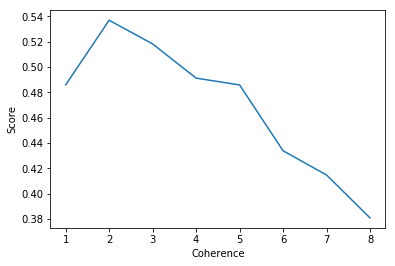

In [69]:
Coherence(max_topic=8, text=data_nouns)

In [70]:
# 2 Topics seems gave the best result
lda = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)        
lda.show_topics(formatted=False)

[(0,
  [('doctor', 0.1223256984646363),
   ('hospital', 0.06732947394915681),
   ('check', 0.02504404731940599),
   ('day', 0.02170903599295243),
   ('pay', 0.019506670022652908),
   ('treatment', 0.018499874150515985),
   ('time', 0.018185250440473193),
   ('medicine', 0.01768185250440473),
   ('money', 0.014158066951925497),
   ('emergency', 0.012270324691668765)]),
 (1,
  [('service', 0.06726052155951459),
   ('wait', 0.04989672088820036),
   ('patient', 0.042602633617350893),
   ('time', 0.03524399690162665),
   ('room', 0.03395300800413117),
   ('people', 0.03150012909888975),
   ('staff', 0.0226568551510457),
   ('security', 0.022592305706170927),
   ('hour', 0.022205009036922282),
   ('nurse', 0.020333075135553835)])]

Data from Nouns only seems didn't have good result, skip to N and ADJ.

## **LDA N , ADJ.**

In [36]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [37]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(df_train_bad.en.apply(nouns_adj))

In [38]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.en)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index

In [39]:
corpus = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2word = dict((v, k) for k, v in cvna.vocabulary_.items())
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

  0%|          | 0/8 [00:00<?, ?it/s]


Number of topic: 1 

(0, '0.048*"doctor" + 0.030*"hospital" + 0.025*"patient" + 0.025*"service" + 0.021*"wait" + 0.020*"time" + 0.020*"nurse" + 0.017*"bad" + 0.013*"good" + 0.013*"room"')


 12%|█▎        | 1/8 [00:36<04:17, 36.85s/it]


 Coherence Score: 0.4356478409784904

Number of topic: 2 

(0, '0.051*"service" + 0.046*"patient" + 0.042*"wait" + 0.041*"time" + 0.040*"nurse" + 0.034*"bad" + 0.027*"good" + 0.026*"room" + 0.024*"people" + 0.019*"check"')
(1, '0.094*"doctor" + 0.060*"hospital" + 0.017*"security" + 0.016*"day" + 0.015*"social" + 0.015*"medicine" + 0.015*"pay" + 0.014*"treatment" + 0.012*"appointment" + 0.011*"money"')


 25%|██▌       | 2/8 [01:14<03:42, 37.15s/it]


 Coherence Score: 0.4708855974412214

Number of topic: 3 

(0, '0.062*"wait" + 0.060*"time" + 0.044*"patient" + 0.038*"room" + 0.029*"check" + 0.025*"hour" + 0.024*"staff" + 0.021*"long" + 0.019*"nurse" + 0.019*"sit"')
(1, '0.076*"service" + 0.053*"hospital" + 0.050*"bad" + 0.040*"good" + 0.040*"nurse" + 0.027*"patient" + 0.023*"pay" + 0.022*"work" + 0.021*"treatment" + 0.021*"speak"')
(2, '0.143*"doctor" + 0.038*"hospital" + 0.025*"security" + 0.025*"day" + 0.023*"social" + 0.023*"medicine" + 0.017*"department" + 0.014*"emergency" + 0.013*"home" + 0.011*"drug"')


 38%|███▊      | 3/8 [01:52<03:06, 37.27s/it]


 Coherence Score: 0.46118089340638346

Number of topic: 4 

(0, '0.182*"doctor" + 0.032*"day" + 0.029*"medicine" + 0.029*"pay" + 0.027*"treatment" + 0.020*"money" + 0.020*"hospital" + 0.017*"treat" + 0.016*"home" + 0.014*"drug"')
(1, '0.104*"service" + 0.092*"patient" + 0.069*"bad" + 0.055*"good" + 0.049*"people" + 0.031*"work" + 0.029*"speak" + 0.026*"terrible" + 0.023*"department" + 0.019*"lot"')
(2, '0.101*"hospital" + 0.079*"nurse" + 0.050*"room" + 0.033*"staff" + 0.019*"child" + 0.019*"emergency" + 0.018*"examination" + 0.017*"card" + 0.015*"sick" + 0.014*"blood"')
(3, '0.085*"wait" + 0.082*"time" + 0.039*"check" + 0.035*"security" + 0.034*"hour" + 0.031*"social" + 0.028*"long" + 0.025*"sit" + 0.024*"appointment" + 0.022*"queue"')


 50%|█████     | 4/8 [02:29<02:29, 37.34s/it]


 Coherence Score: 0.44329315112955203

Number of topic: 5 

(0, '0.103*"wait" + 0.100*"time" + 0.047*"check" + 0.041*"hour" + 0.034*"long" + 0.031*"sit" + 0.030*"appointment" + 0.026*"queue" + 0.022*"examination" + 0.021*"card"')
(1, '0.130*"patient" + 0.101*"nurse" + 0.065*"room" + 0.033*"terrible" + 0.025*"child" + 0.024*"emergency" + 0.020*"care" + 0.016*"floor" + 0.015*"walk" + 0.013*"night"')
(2, '0.156*"hospital" + 0.043*"security" + 0.042*"day" + 0.039*"social" + 0.022*"bad" + 0.021*"home" + 0.018*"blood" + 0.016*"answer" + 0.015*"eat" + 0.014*"year"')
(3, '0.129*"service" + 0.068*"good" + 0.064*"bad" + 0.060*"people" + 0.043*"staff" + 0.036*"speak" + 0.022*"work" + 0.021*"talk" + 0.019*"poor" + 0.019*"department"')
(4, '0.227*"doctor" + 0.036*"medicine" + 0.036*"pay" + 0.034*"treatment" + 0.026*"money" + 0.021*"treat" + 0.017*"drug" + 0.017*"symptom" + 0.015*"medical" + 0.015*"sleep"')


 62%|██████▎   | 5/8 [03:07<01:52, 37.57s/it]


 Coherence Score: 0.4608095141169608

Number of topic: 6 

(0, '0.125*"wait" + 0.121*"time" + 0.055*"check" + 0.051*"security" + 0.050*"hour" + 0.046*"social" + 0.041*"long" + 0.037*"sit" + 0.032*"queue" + 0.027*"examination"')
(1, '0.265*"doctor" + 0.046*"day" + 0.032*"medicine" + 0.020*"symptom" + 0.018*"eat" + 0.018*"medical" + 0.014*"mother" + 0.014*"medication" + 0.013*"pain" + 0.012*"surgery"')
(2, '0.157*"service" + 0.104*"bad" + 0.083*"good" + 0.073*"people" + 0.046*"patient" + 0.032*"lot" + 0.024*"poor" + 0.019*"answer" + 0.019*"system" + 0.019*"walk"')
(3, '0.186*"hospital" + 0.046*"pay" + 0.043*"treatment" + 0.033*"money" + 0.026*"home" + 0.020*"drug" + 0.019*"sleep" + 0.019*"expensive" + 0.016*"change" + 0.016*"car"')
(4, '0.052*"staff" + 0.045*"work" + 0.043*"speak" + 0.037*"appointment" + 0.034*"department" + 0.026*"card" + 0.026*"today" + 0.023*"talk" + 0.022*"person" + 0.017*"word"')
(5, '0.118*"nurse" + 0.106*"patient" + 0.076*"room" + 0.039*"terrible" + 0.028*"emerge

 75%|███████▌  | 6/8 [03:45<01:15, 37.68s/it]


 Coherence Score: 0.42424148066665596

Number of topic: 7 

(0, '0.145*"nurse" + 0.093*"room" + 0.051*"speak" + 0.034*"emergency" + 0.029*"care" + 0.027*"talk" + 0.023*"floor" + 0.022*"walk" + 0.020*"night" + 0.019*"change"')
(1, '0.087*"hospital" + 0.052*"pay" + 0.038*"money" + 0.030*"home" + 0.023*"treat" + 0.022*"sleep" + 0.022*"answer" + 0.020*"expensive" + 0.017*"insurance" + 0.017*"baht"')
(2, '0.188*"service" + 0.125*"bad" + 0.099*"good" + 0.062*"security" + 0.057*"social" + 0.041*"department" + 0.039*"terrible" + 0.028*"poor" + 0.022*"word" + 0.016*"free"')
(3, '0.307*"doctor" + 0.053*"day" + 0.048*"medicine" + 0.023*"drug" + 0.023*"symptom" + 0.019*"medical" + 0.017*"month" + 0.016*"medication" + 0.015*"pain" + 0.012*"disease"')
(4, '0.084*"people" + 0.060*"staff" + 0.052*"work" + 0.042*"appointment" + 0.037*"lot" + 0.030*"card" + 0.030*"today" + 0.026*"person" + 0.018*"car" + 0.016*"understand"')
(5, '0.175*"patient" + 0.127*"hospital" + 0.050*"treatment" + 0.034*"child" + 0

 88%|████████▊ | 7/8 [04:23<00:37, 37.82s/it]


 Coherence Score: 0.3805635401987088

Number of topic: 8 

(0, '0.171*"wait" + 0.164*"time" + 0.068*"hour" + 0.056*"long" + 0.051*"sit" + 0.043*"queue" + 0.036*"examination" + 0.034*"check" + 0.028*"minute" + 0.026*"people"')
(1, '0.202*"service" + 0.132*"bad" + 0.107*"good" + 0.069*"people" + 0.032*"lot" + 0.031*"poor" + 0.025*"expensive" + 0.021*"car" + 0.018*"place" + 0.016*"park"')
(2, '0.067*"staff" + 0.056*"work" + 0.048*"appointment" + 0.044*"department" + 0.034*"card" + 0.034*"today" + 0.026*"medical" + 0.025*"system" + 0.021*"receive" + 0.019*"waste"')
(3, '0.311*"doctor" + 0.042*"check" + 0.029*"symptom" + 0.028*"blood" + 0.023*"treat" + 0.019*"fever" + 0.016*"eye" + 0.015*"disease" + 0.014*"matter" + 0.014*"insurance"')
(4, '0.101*"room" + 0.081*"nurse" + 0.038*"child" + 0.037*"emergency" + 0.031*"care" + 0.025*"floor" + 0.024*"walk" + 0.021*"night" + 0.020*"relative" + 0.018*"sick"')
(5, '0.211*"patient" + 0.080*"nurse" + 0.058*"speak" + 0.054*"terrible" + 0.038*"talk" + 0

100%|██████████| 8/8 [05:02<00:00, 37.78s/it]


 Coherence Score: 0.3979401213066742


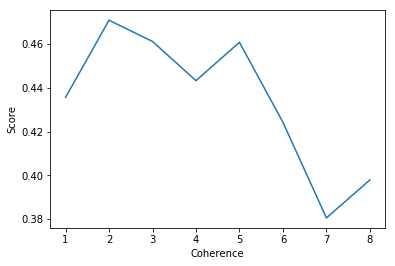

In [77]:
Coherence(max_topic=8,text=data_nouns_adj.en)

In [78]:
#2,5 Topics seems gave best result
lda = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)        
lda.show_topics(formatted=False)

[(0,
  [('hospital', 0.06117419666586132),
   ('service', 0.05054360956752839),
   ('nurse', 0.03957477651606668),
   ('bad', 0.0335346702101957),
   ('patient', 0.027494563904324715),
   ('good', 0.0267697511476202),
   ('room', 0.025416767335105096),
   ('people', 0.023580575018120317),
   ('staff', 0.01696061850688572),
   ('security', 0.01657405170330998)]),
 (1,
  [('doctor', 0.09537752604041665),
   ('wait', 0.04152066433062929),
   ('time', 0.04008064129026064),
   ('patient', 0.023280372485959776),
   ('check', 0.019104305668890702),
   ('day', 0.01656026496423943),
   ('hour', 0.01651226419622714),
   ('medicine', 0.015072241155858493),
   ('long', 0.013632218115489848),
   ('sit', 0.012384198147170355)])]

In [42]:

lda = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)        
lda.show_topics(formatted=False)

[(0,
  [('nurse', 0.08653446123977257),
   ('good', 0.07502426847871307),
   ('room', 0.07003189571488004),
   ('terrible', 0.0352239633892664),
   ('nurses', 0.027596727222299264),
   ('emergency', 0.02745805020108168),
   ('service', 0.0228817085009014),
   ('expensive', 0.01830536680072112),
   ('front', 0.017889335737068367),
   ('child', 0.0176119816946332)]),
 (1,
  [('time', 0.09568354937859147),
   ('patient', 0.07416811439262327),
   ('long', 0.04129359882400107),
   ('wait', 0.03541360416945075),
   ('appointment', 0.03274087932647334),
   ('queue', 0.031939061873580116),
   ('clock', 0.028464519577709475),
   ('department', 0.028330883335560605),
   ('examination', 0.02418815982894561),
   ('hours', 0.021114526259521583)]),
 (2,
  [('doctor', 0.2422918807810894),
   ('medicine', 0.041109969167523124),
   ('treatment', 0.03764131551901336),
   ('day', 0.03198869475847893),
   ('today', 0.022482014388489208),
   ('symptoms', 0.019141829393627956),
   ('mother', 0.0168293936279

In [43]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, d)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029336 -0.053096       1        1  39.059986
2     -0.057474 -0.122602       2        1  23.928495
3     -0.109433  0.140944       3        1  19.741131
1      0.196243  0.034753       4        1  17.270388, topic_info=         Term         Freq        Total Category  logprob  loglift
228  security   328.000000   328.000000  Default  30.0000  30.0000
15     doctor  1611.000000  1611.000000  Default  29.0000  29.0000
227    social   299.000000   299.000000  Default  28.0000  28.0000
25   patients   571.000000   571.000000  Default  27.0000  27.0000
503     queue   227.000000   227.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
81       baht    37.279629   211.292953   Topic4  -5.2312   0.0214
287     today    34.140652   174.566284   Topic4  -5.3192   0.1244
705     fever    32.429752   120.550613   Topic4  -5.3706   0.4432
218  terrible    32.864662   233.708069   Topic4  -5.3573  -0.2055
3       nurse    34.410309   534.472778   Topic4  -5.3113  -0.9867

[305 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2206      4  0.974412  additional
360       1  0.979257         air
210       3  0.941589      amount
539       1  0.326970      answer
539       2  0.145320      answer
...     ...       ...         ...
139       1  0.264864       wound
139       2  0.038761       wound
139       3  0.562028       wound
139       4  0.135662       wound
1703      4  0.974478        zeng

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

# Test DATA

In [44]:
data_nouns_adj = pd.DataFrame(df_test_bad.en.apply(nouns_adj))

## Ramathibodi

In [45]:
#Test data
#Choose the hopsital to test
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna_bad= cvna.fit_transform(data_nouns_adj.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].en)
data_dtmna = pd.DataFrame(data_cvna_bad.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].index


tdm = data_dtmna.T
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
#Create Dictionary
id2word = dict((v, k) for k, v in cvna.vocabulary_.items())
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id
ldaR = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)        
ldaR.show_topics(formatted=False)

[(0,
  [('hospital', 0.12834224598930483),
   ('staff', 0.09090909090909091),
   ('people', 0.0748663101604278),
   ('queue', 0.06417112299465241),
   ('afternoon', 0.0427807486631016),
   ('long', 0.0374331550802139),
   ('floor', 0.0374331550802139),
   ('card', 0.03208556149732621),
   ('drug', 0.0213903743315508),
   ('services', 0.0213903743315508)]),
 (1,
  [('patients', 0.12650602409638553),
   ('treatment', 0.06626506024096386),
   ('relatives', 0.04819277108433735),
   ('emergency', 0.04216867469879518),
   ('building', 0.03614457831325301),
   ('blood', 0.030120481927710843),
   ('appointment', 0.024096385542168676),
   ('documents', 0.024096385542168676),
   ('hand', 0.018072289156626505),
   ('ramathibodi', 0.018072289156626505)]),
 (2,
  [('service', 0.12418300653594772),
   ('bad', 0.11764705882352941),
   ('lot', 0.058823529411764705),
   ('system', 0.0457516339869281),
   ('sick', 0.0392156862745098),
   ('line', 0.026143790849673203),
   ('talk', 0.026143790849673203),

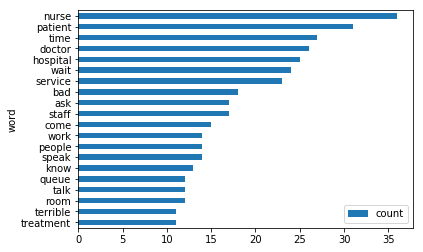

In [26]:
# most frequent words
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

Not much informative compare to vanilla model

In [46]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, d)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010821  0.123316       1        1  33.675316
4     -0.124064 -0.033732       2        1  31.786266
3      0.089622 -0.057204       3        1  18.193161
2      0.013082 -0.020188       4        1  11.868409
0      0.010539 -0.012192       5        1   4.476848, topic_info=          Term      Freq      Total Category  logprob  loglift
27       queue  9.000000   9.000000  Default  30.0000  30.0000
24    building  4.000000   4.000000  Default  29.0000  29.0000
96      nurses  6.000000   6.000000  Default  28.0000  28.0000
154       poor  5.000000   5.000000  Default  27.0000  27.0000
70   treatment  8.000000   8.000000  Default  26.0000  26.0000
..         ...       ...        ...      ...      ...      ...
77   relatives  0.417194   6.230186   Topic5  -4.6276   0.4026
90       uncle  0.069437   1.202656   Topic5  -6.4207   0.2544
91       aches  0.069437   1.202656   Topic5  -6.4207   0.2544
89     patient  0.416860   7.760156   Topic5  -4.6284   0.1822
36         bad  0.417115  13.588361   Topic5  -4.6278  -0.3774

[276 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7         4  0.562833        2nd
321       3  0.771937      achan
91        4  0.831493      aches
102       1  0.707320     adults
43        1  0.322500  afternoon
...     ...       ...        ...
178       3  0.293215       work
178       4  0.293215       work
66        4  0.831373      wound
245       2  0.922252      wrong
123       3  0.771937       xray

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

## Word Cloud

In [243]:
taksinbad = ' '.join(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลตากสิน'].en)
ramabad = ' '.join(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].en)
pytbad = ' '.join(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลพญาไท 2'].en)
taksingood = ' '.join(df_test_good.loc[df_test_good.hospital == 'โรงพยาบาลตากสิน'].en)
ramagood = ' '.join(df_test_good.loc[df_test_good.hospital == 'โรงพยาบาลรามาธิบดี'].en)
pytgood = ' '.join(df_test_good.loc[df_test_good.hospital == 'โรงพยาบาลพญาไท 2'].en)

In [268]:
stopwords = set(STOPWORDS)
stopwords.add("PRON")
stopwords.add("hospital")
stopwords.add("patient")
stopwords.add("good")
stopwords.add("service")
stopwords.add("department")
def gen_wordcloud(model=lda,hosp=None,sent='bad'): 
    color = 'black' if sent == 'bad' else 'white'
    word = []
    for i in range(lda.num_topics):
        for j in lda.show_topic(i):
            word.append(j[0])
    wordcloud = WordCloud(background_color=color, 
                          stopwords=stopwords, min_font_size = 7,
                          max_words=1000,
                          collocations=False).generate(hosp)
    plt.figure(figsize=(20,14))
    plt.imshow(wordcloud)

## Phyathai 2 Hospital

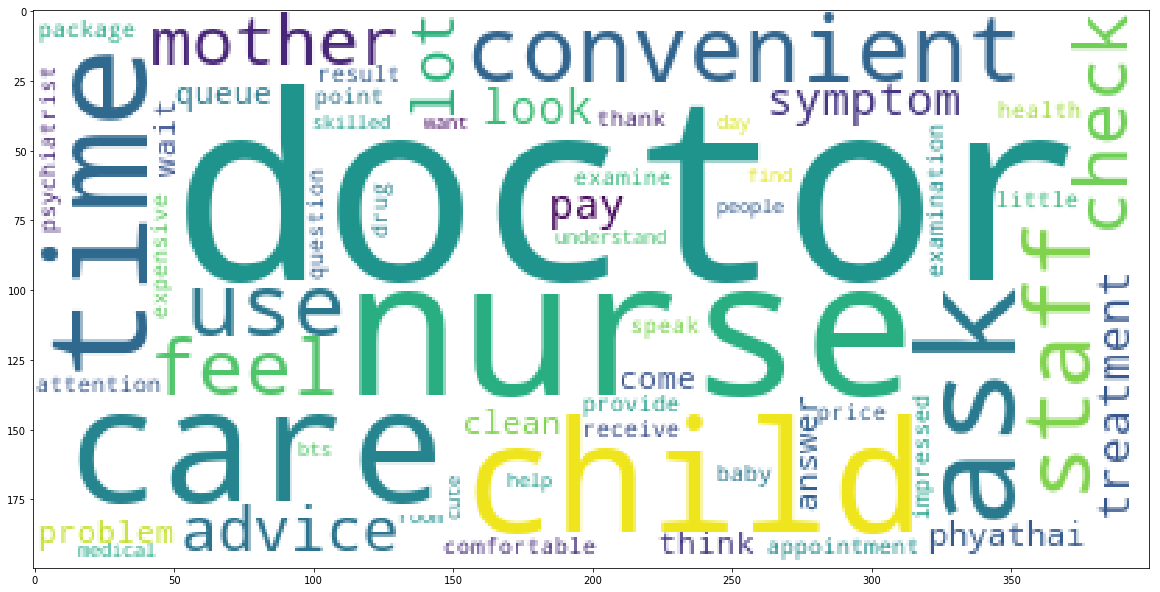

In [269]:
gen_wordcloud(hosp=pytgood,sent='good')

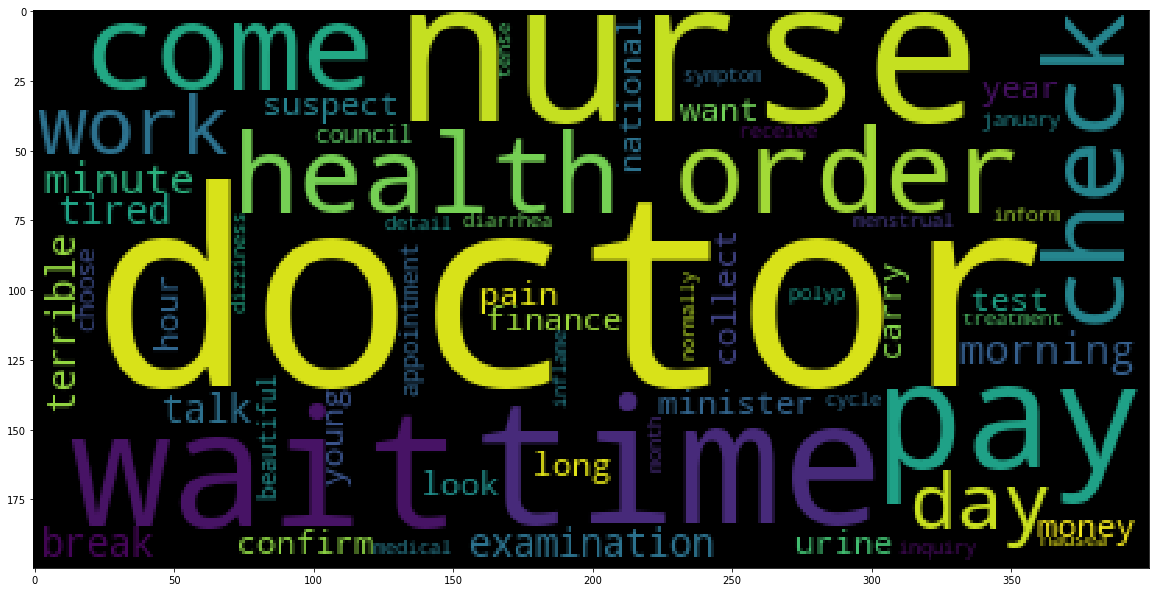

In [270]:
gen_wordcloud(hosp=pytbad,sent='bad')

## Ramathibodi hospital

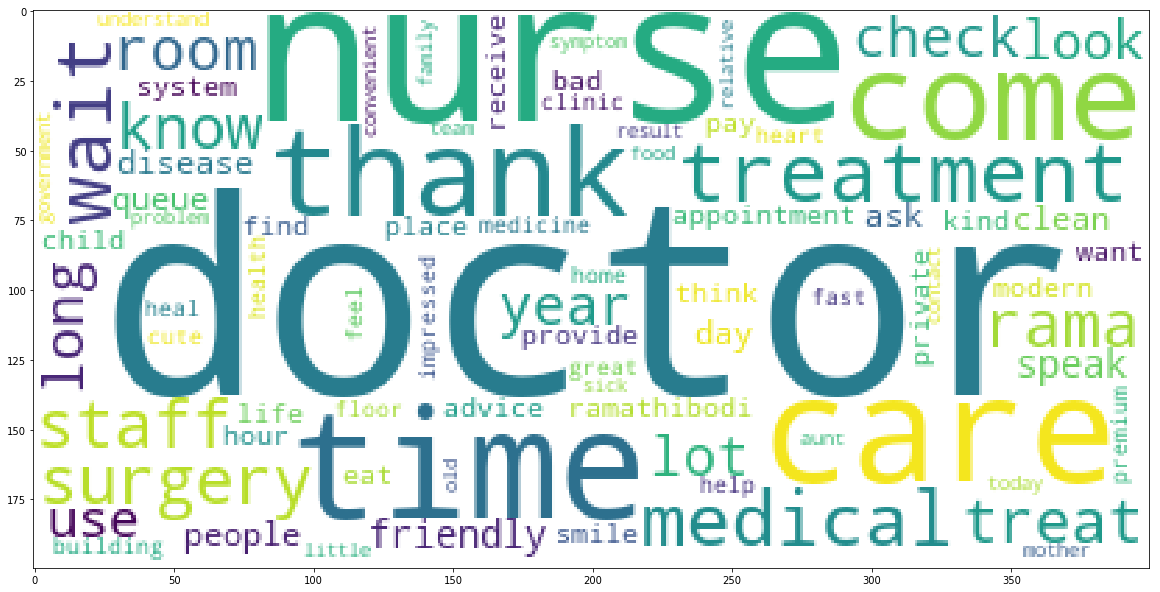

In [271]:
gen_wordcloud(hosp=ramagood,sent='good')

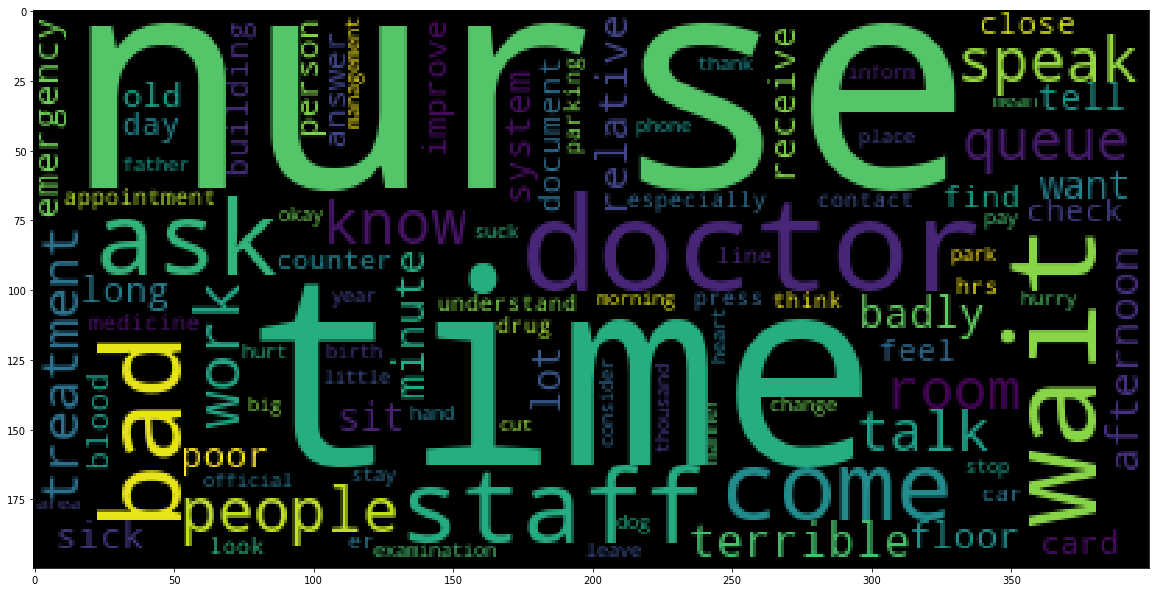

In [272]:
gen_wordcloud(hosp=ramabad,sent='bad')

## Taksin hospital

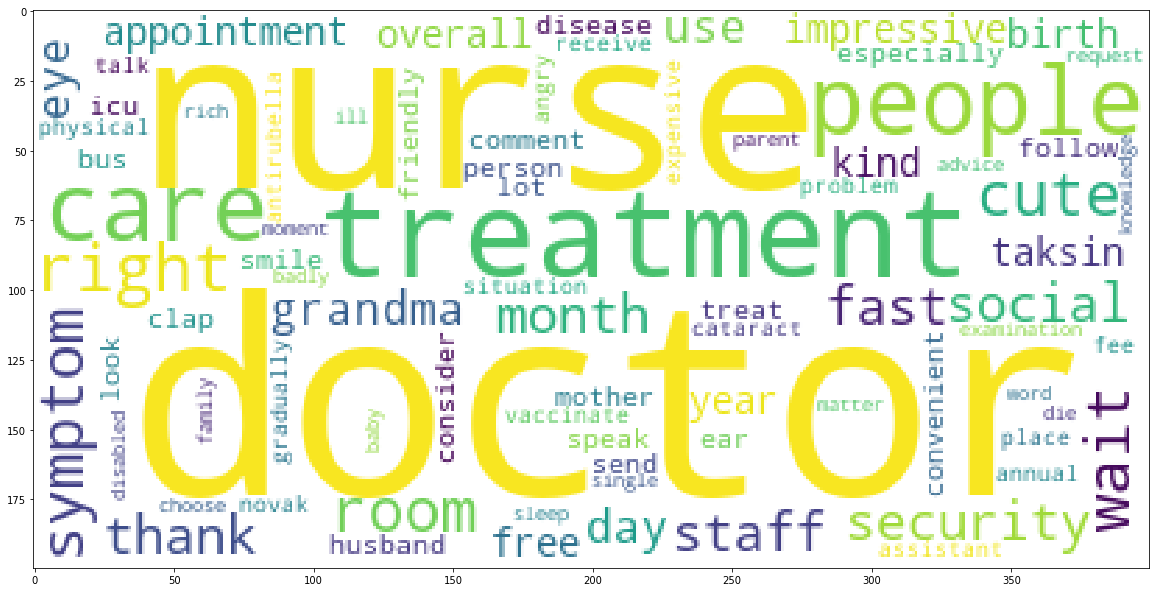

In [273]:
gen_wordcloud(hosp=taksingood,sent='good')

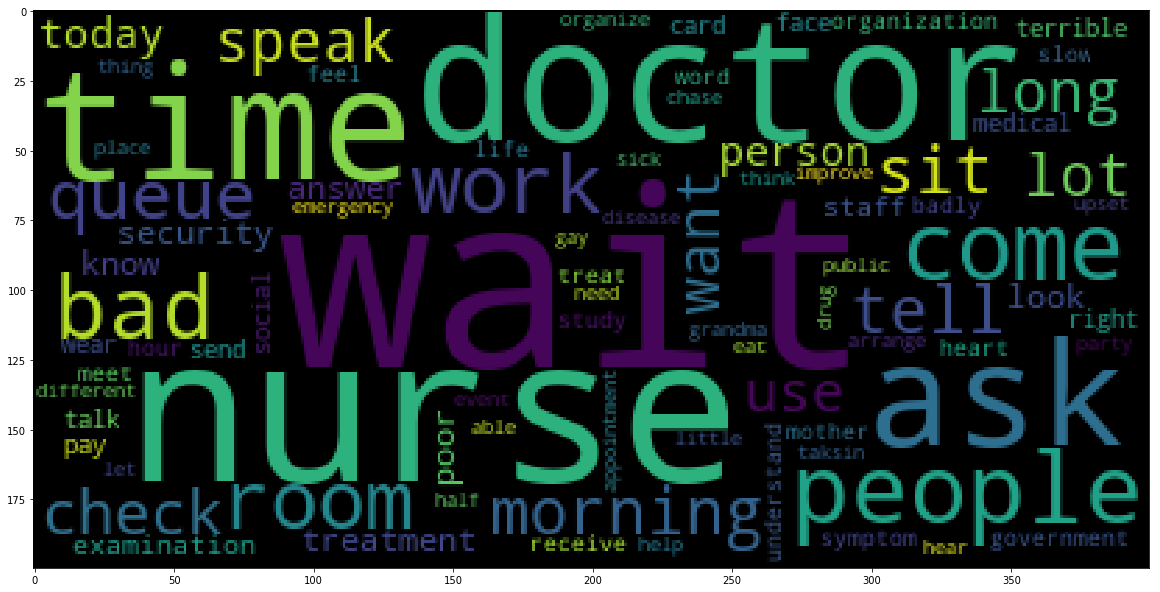

In [274]:
gen_wordcloud(hosp=taksinbad,sent='bad')

## Radar plot

In [22]:
#Define axis
bad=['time','speak','wait','emergency','car','drug','talk','staff','service','queue']

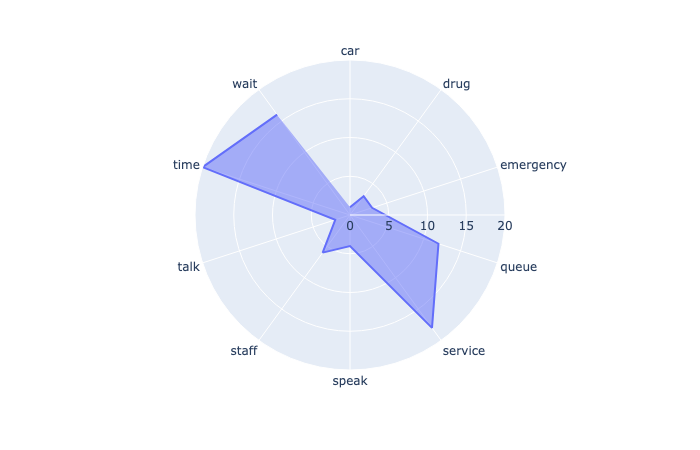

In [31]:
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลตากสิน'].en)
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})
r = word_count.loc[word_count.word.isin(bad)].reset_index()
fig = px.line_polar(r, r='count', theta='word')
fig.update_traces(fill='toself')
fig.show("png")

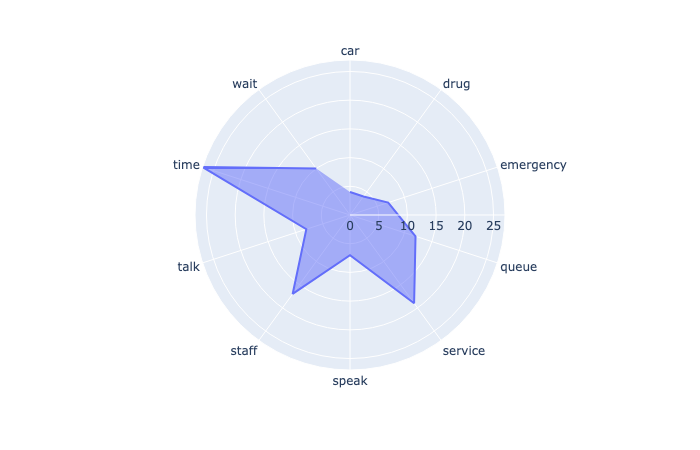

In [33]:
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลรามาธิบดี'].en)
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})
r = word_count.loc[word_count.word.isin(bad)].reset_index()
fig = px.line_polar(r, r='count', theta='word')
fig.update_traces(fill='toself')
fig.show("png")

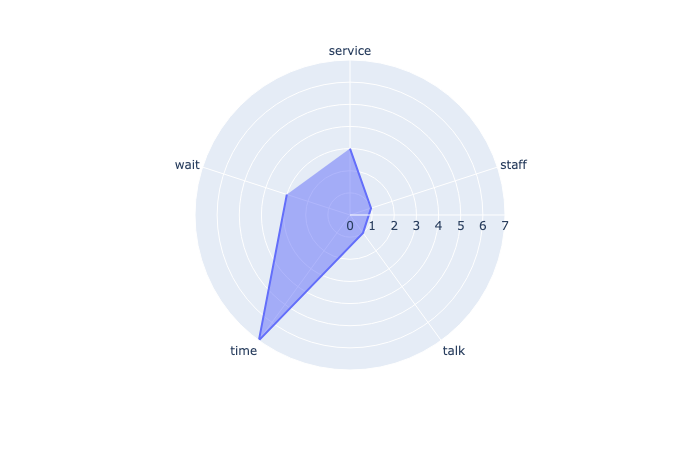

In [34]:
data_cv_bad= cv.fit_transform(df_test_bad.loc[df_test_bad.hospital == 'โรงพยาบาลพญาไท 2'].en)
word_count = pd.DataFrame({'word': cv.get_feature_names(), 'count': np.asarray(data_cv_bad.sum(axis=0))[0]})
r = word_count.loc[word_count.word.isin(bad)].reset_index()
fig = px.line_polar(r, r='count', theta='word')
fig.update_traces(fill='toself')
fig.show("png")